In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("/Users/semanurcan/Desktop/veri/merged_all_months.csv")
df.head()

,date,hour,route_code,stop_code,passenger_count,vehicle_type,district,is_outlier,is_peak_hour,day_of_week,is_weekend,mean_passenger_by_route_hour,month
0,2024-08-01,0,MESCIDI SELAM-ARNAVUTKOY-ISTANBUL HAVA LIMANI,OTOYOL,1,1,ATASEHIR,0,0,3,0,1.782609,bilinmeyen_ay
1,2024-08-01,0,MECIDIYEKOY-ISTANBUL HAVALIMANI,OTOYOL,1,1,ATASEHIR,0,0,3,0,1.200000,bilinmeyen_ay
2,2024-08-01,0,KOC UNV. RUMELIFENER KAMPUSU - TAKSIM,OTOYOL,3,1,ATASEHIR,0,0,3,0,1.666667,bilinmeyen_ay
3,2024-08-01,0,HACI OSMAN METRO - RUMELI FENERI,OTOYOL,1,1,ATASEHIR,0,0,3,0,1.538462,bilinmeyen_ay
4,2024-08-01,0,USKUDAR-GUZELTEPE-UMRANIYE DEVLET HASTANESI,OTOYOL,3,1,BAKIRKOY,0,0,3,0,4.258065,bilinmeyen_ay


In [3]:
df['district'] = df['district'].fillna('UNKNOWN')

Yolcu yoğunluğunu temsil eden density_level değişkeni passenger_count üzerinden sınıflandırılarak oluşturulmuştur.
Yoğunluk seviyeleri tanımlanmıştır:

- **Low:** 0–50 yolcu

- **Medium:** 51–150 yolcu

- **High:** 150+ yolcu

Bu sınıflandırma, veri setindeki yoğunluk seviyelerini kategorik hale getirerek modelin sınıflandırma işlemlerinde kullanılmasını sağlamaktadır.

In [4]:
bins = [0, 50, 150, np.inf]
labels = ['Low', 'Medium', 'High']

df['density_level'] = pd.cut(df['passenger_count'], bins=bins, labels=labels)
df['density_level'].value_counts()

density_level
Low       2914425
Medium      45738
High        10529
Name: count, dtype: int64

Modelin öğrenmesi için kullanılacak featuresve target belirlenmiştir.
Modelde kullanılacak giriş değişkenleri:

- **hour:** Biniş saati

- **district:** İlçe bilgisi

- **vehicle_type:** Taşıt türü

In [5]:
feature_cols = ['hour', 'district', 'vehicle_type']
X = df[feature_cols]
y = df['density_level']

Modelin eğitileceği ve doğrulanacağı veri setleri oluşturulmuştur.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y   
)

Kategorik değişkenlerin sayısal değerlere dönüştürülmesi
district değişkeni kategorik olduğu için LabelEncoder kullanılarak sayısal forma çevrilmiştir.

Aynı encoder hem X_train hem X_test üzerinde uygulanmıştır.

In [7]:
cat_cols = ['district']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    encoders[col] = le

Yolcu yoğunluk seviyesini tahmin etmek için Decision Tree Classifier modeli uygulanmıştır.
Model, önceden eğitime hazır hale getirilen X_train ve y_train veri setleri üzerinde eğitilmiştir.
Eğitilen model ile X_test üzerinde tahmin (predict) işlemi yapılmıştır.

Model performansı üç temel metrik ile değerlendirilmiştir:

- **Accuracy** (Doğruluk)

- **Classification Report** (Precision, Recall, F1-score)

- **Confusion Matrix** (Karışıklık Matrisi)

In [8]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9810566214303387


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        High       0.00      0.00      0.00      2106
         Low       0.98      1.00      0.99    582885
      Medium       0.00      0.00      0.00      9148

    accuracy                           0.98    594139
   macro avg       0.33      0.33      0.33    594139
weighted avg       0.96      0.98      0.97    594139

[[     0   2106      0]
 [     1 582884      0]
 [     0   9148      0]]


Random Forest Classifier ile model eğitimi yapılmıştır.
Yolcu yoğunluğu sınıflarını (`Low`, `Medium`, `High`) tahmin etmek için
Random Forest Classifier modeli kullanılmıştır.

In [9]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.9810566214303387


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        High       0.00      0.00      0.00      2106
         Low       0.98      1.00      0.99    582885
      Medium       0.00      0.00      0.00      9148

    accuracy                           0.98    594139
   macro avg       0.33      0.33      0.33    594139
weighted avg       0.96      0.98      0.97    594139

[[     0   2106      0]
 [     1 582884      0]
 [     0   9148      0]]


Decision Tree ve Random Forest modellerinin test verisi üzerindeki performansını karşılaştırmak için bir tablo oluşturulmuştur.

In [10]:
results_sema = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, y_pred_dt),
                 accuracy_score(y_test, y_pred_rf)]
})

results_sema

,Model,Accuracy
0,Decision Tree,0.981057
1,Random Forest,0.981057


veri setindeki `density_level` etiketlerinin dağılımı incelenmiş ve 
sınıflar arasında ciddi bir dengesizlik olduğu görülmüştür. 

- **Low** sınıfı çok yüksektir  

- **Medium** orta seviyededir 

- **High** sınıfı oldukça azdır 

In [11]:
from sklearn.utils import resample

df_low = df[df['density_level'] == 'Low']
df_med = df[df['density_level'] == 'Medium']
df_high = df[df['density_level'] == 'High']

df_low_down = resample(df_low,
                       replace=False,
                       n_samples=len(df_med),
                       random_state=42)

df_balanced = pd.concat([df_low_down, df_med, df_high])

df_balanced['density_level'].value_counts()

density_level
Low       45738
Medium    45738
High      10529
Name: count, dtype: int64

Sınıf dengesizliği giderildikten sonra oluşturduğumuz yeni veri seti 
`df_balanced` kullanılarak modelde kullanılacak features ve target belirlenmiştir.

In [12]:
X = df_balanced[feature_cols]
y = df_balanced['density_level']

Dengelenmiş veri seti, modelin eğitimi ve performans değerlendirmesi için %80 eğitim ve %20 test olarak ayrılmıştır.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Dengelenmiş veri setinde sınıf dağılımını kontrol etmek amacıyla her yoğunluk seviyesinin kaç örnek içerdiği görüntülenmiştir.

In [14]:
df_balanced['density_level'].value_counts()

density_level
Low       45738
Medium    45738
High      10529
Name: count, dtype: int64

Eğitim ve test veri kümelerinde `district` değişkeninin farklı encode edilmesini önlemek için 
her iki veri kümesi birleştirilmiş, tek bir LabelEncoder ile dönüştürülmüş ve ardından Decision Tree modeli yeniden eğitilmiştir.

- **concat()** → Train ve test verileri geçici olarak birleştirildi.  
- **LabelEncoder()** → `district` tüm veri için tek seferde encode edildi.  
- **dt.fit()** → Decision Tree modeli düzeltilmiş veri ile yeniden eğitildi.  
- **classification_report & confusion_matrix** → Model performansı değerlendirildi.


In [15]:
combined = pd.concat([X_train.copy(), X_test.copy()], axis=0)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

combined['district'] = le.fit_transform(combined['district'].astype(str))

X_train['district'] = combined.iloc[:len(X_train)]['district'].values
X_test['district'] = combined.iloc[len(X_train):]['district'].values

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 0.599431400421548
              precision    recall  f1-score   support

        High       0.31      0.02      0.04      2106
         Low       0.69      0.58      0.63      9148
      Medium       0.55      0.75      0.64      9147

    accuracy                           0.60     20401
   macro avg       0.51      0.45      0.43     20401
weighted avg       0.59      0.60      0.57     20401

[[  46  233 1827]
 [  34 5280 3834]
 [  70 2174 6903]]


dengelenmiş eğitim verisi kullanılarak Random Forest modeli oluşturulmuş, 
eğitilmiş ve test verisi üzerinde tahmin performansı ölçülmüştür.

In [16]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.5995784520366648
              precision    recall  f1-score   support

        High       0.29      0.02      0.03      2106
         Low       0.69      0.58      0.63      9148
      Medium       0.55      0.76      0.64      9147

    accuracy                           0.60     20401
   macro avg       0.51      0.45      0.43     20401
weighted avg       0.58      0.60      0.57     20401

[[  33  227 1846]
 [  25 5262 3861]
 [  56 2154 6937]]


Random Forest modelinde özelliklerin önem düzeyleri

/var/folders/yx/00gnd8sx2xx9ds0l_2rt15vr0000gn/T/ipykernel_97636/3320501476.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="mako")


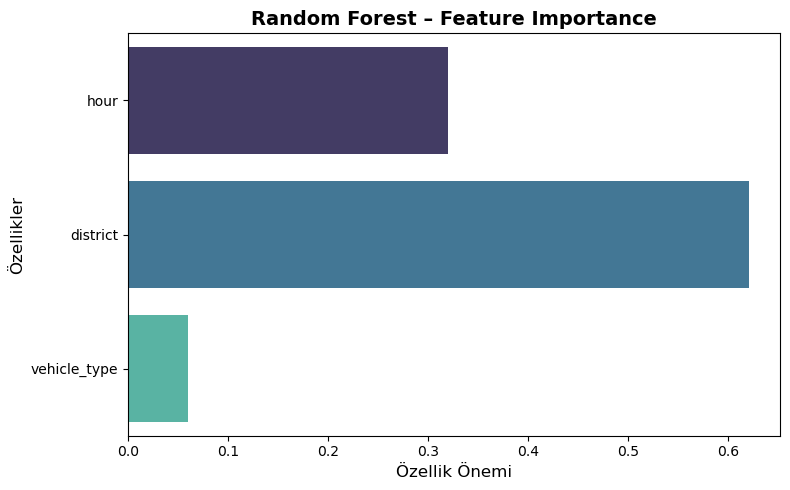

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
importances = rf.feature_importances_
features = X_train.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="mako")
plt.title("Random Forest – Feature Importance", fontsize=14, fontweight='bold')
plt.xlabel("Özellik Önemi", fontsize=12)
plt.ylabel("Özellikler", fontsize=12)
plt.tight_layout()
plt.show()

Random Forest modelinin gerçek ve tahmin edilen değerleri

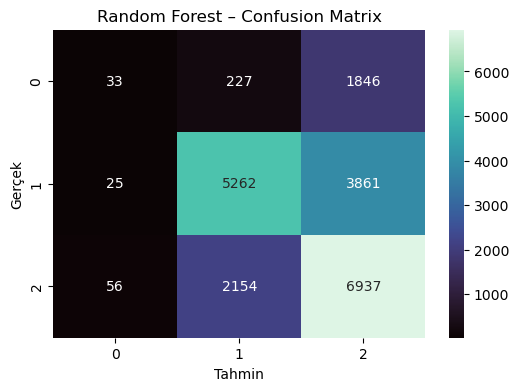

In [18]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="mako")
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

Decision Tree ve Random Forest modellerinin doğruluk performanslarının karşılaştırılması

/var/folders/yx/00gnd8sx2xx9ds0l_2rt15vr0000gn/T/ipykernel_97636/2784067282.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="mako")


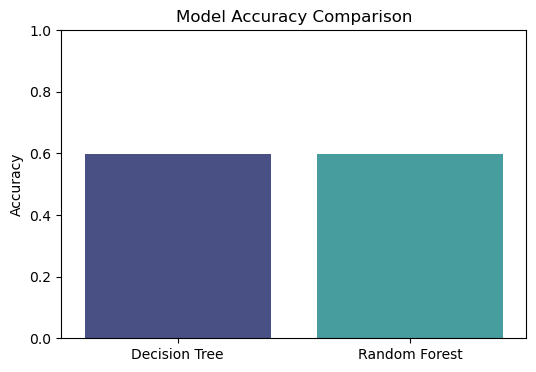

In [19]:
models = ["Decision Tree", "Random Forest"]
accuracies = [accuracy_score(y_test, y_pred_dt),
              accuracy_score(y_test, y_pred_rf)]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies, palette="mako")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

Random Forest – Özelliklerin Yüzdesel Önem Dağılımı

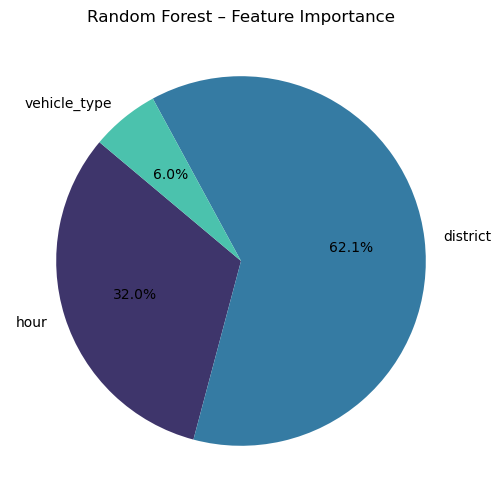

In [20]:
plt.figure(figsize=(6,6))
plt.pie(importances, labels=features, autopct="%1.1f%%", 
        startangle=140, colors=sns.color_palette("mako", len(importances)))
plt.title("Random Forest – Feature Importance")
plt.show()

Dengelenmiş yoğunluk sınıflarının dağılımı

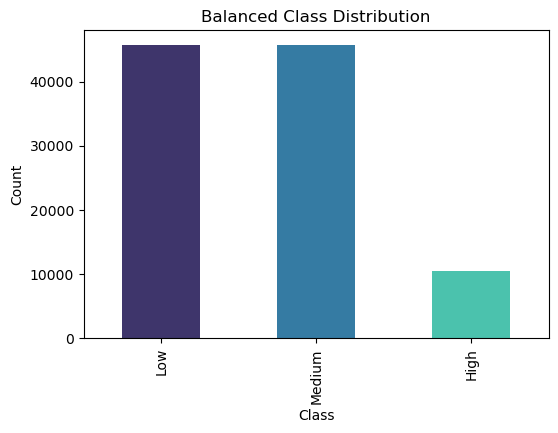

In [21]:
plt.figure(figsize=(6,4))
df_balanced['density_level'].value_counts().plot(
    kind='bar',
    color=sns.color_palette("mako", 3)
)
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()